In [1]:
from google.colab import drive
drive.mount('/content/drive')
gdrive_path = '/content/drive/MyDrive/' # hopefully

Mounted at /content/drive


In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pytorch-segmentation-models-lib:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1701116%2F2786089%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240915%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240915T163713Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db6ce86a941587e3340ff511af8582a403d3bdb9dd57bc52b8396abd09ae6954c146c6c4b3c9bb199fadaf4235ee32018767533c0f891822feff8e367e16ed507c434ef92adeaa503f4fce7b12e24a9de490d141e03485970b43ddba58052256932299c9bb35db161c13327623b3c9c63f11b909664d83ee2b730cec7663e9b35aa9e7e5b924fe1fd6947323fbc9cbc5f09cf686cd3e0f19806e6676ea136fa06a2492320c39ee77e936dd2d221e23811beb69fee28bad6cabfe65c9223dd2fdf007b8ab1ce8a0876537fcbe8fde35b7e8bd919d6a590339ec00e952b21b97c91e39b6601dc54b826fda93cc2ffd1c1b5183336f959eb7fcb11a0532ca2968cdb,uwmgi-mask-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2089184%2F3521209%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240915%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240915T163713Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D093af7fb287e2d25bd620cb975ae7247c95e2d9495f2c3fe029d6c56c115e9e179b0082cb54562ca3cb4671b3b633c6221094ea125906a51e700db505fa517dd96bb7038b582450a22b751ea55df08c216c27c9c8a76c76a1d6b45e91df9baf6f368deaf3e8372b1a6b7d76147e8faeace1a2a570b965b9f60632ad84aaa28826142e57e70e73af139f45d5e8dc6239b9bdf21ded220b6798efe86bdbdba986e9ff5c6a3bbe98b1e19ed86401d7f0d2b03a3b892fdee3f6efe33e9f1a50dc2c75897f4941098e42465f41d36cc7315ab6421634f58b5f56e8e2203ce269d02ff27d0e94b87ac0ce900b7c195946aa023fd6208ae167fa387701f42ebd8a2452f,uwmgi-25d-stride2-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2142905%2F3566043%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240915%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240915T163713Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D30f7c8d02f0a8ec8a85af9600a732062f1e3a01d9aacf0e9f8064338e9ec15cf1150b647c2aef7567b78ad08599c8c7a0ad0a2a77020a1a8d5ce0df10423d7b1e04c9ee1381ebe060def694b1584fa68ff9f0143f84bc609fc2a5979010628c174002241250887a1081851db9c362b67c566178f666622105d406b091efcd0680c2258bed8eb30881ad9b4adec1a15bc01ce8b57b9f099d0a3f59eb756ed2a806e5039c93e104722ac449f253f1ca0c6011fb67bd97a1f1bf3d2f64bdcf7d2ca14ed5856d54d71b6d6c3923bde8e45e64a50f638fc6187b405b3a37f9447ebdc788a5dc7c386f5857ab9685166a546186da4df181212c5350e9d603a7fb07f5f'


KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 548899 bytes downloaded
Downloaded and uncompressed: pytorch-segmentation-models-lib
[==================================================] 81002979 bytes downloaded
Downloaded and uncompressed: uwmgi-mask-dataset
[==================================================] 7609526883 bytes downloaded
Downloaded and uncompressed: uwmgi-25d-stride2-dataset
Data source import complete.


# [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/)
> Track healthy organs in medical scans to improve cancer treatment

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/27923/logos/header.png?t=2021-06-02-20-30-25">

# ⚽ Methodlogy
<img src="https://i.ibb.co/sgsPf4v/Capture.png" width=800>
<img src="https://i.ibb.co/KKtZ7Gn/Picture1-3d.png" width=500>

* In this notebook I'll demonstrate how to train using 2.5D images with **Unet** model using PyTorch.
* 2.5D images take leverage of the extra depth information like our typical RGB image.
* In this notebook I'll be using 3 channels with 2 strides for 2.5D images
* Instead of Resize I'll be using Padding to avoid info loss.
* For mask I'll be using pre-computed 2.5D images & mask from [here](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-stride-2-dataset)
* As there are overlaps between **Stomach**, **Large Bowel** & **Small Bowel** classes, this is a **MultiLabel Segmentation** task, so final activaion should be `sigmoid` instead of `softmax`.
* For data split I'll be using **StratifiedGroupFold** to avoid data leakage due to `case` and to stratify `empty` and `non-empty` mask cases.
* You can play with different models and losses.

## Please Upvote if you Find this Useful :)

# 📒 Notebooks
📌 **2.5D-TransUnet**:
* Train: [UWMGI: TransUNet 2.5D [Train] [TF]](https://www.kaggle.com/code/awsaf49/uwmgi-transunet-2-5d-train-tf)

📌 **2.5D**:
* Train: [UWMGI: 2.5D [Train] [PyTorch]](https://www.kaggle.com/awsaf49/uwmgi-2-5d-train-pytorch/)
* Infer: [UWMGI: 2.5D [Infer] [PyTorch]](https://www.kaggle.com/awsaf49/uwmgi-2-5d-infer-pytorch/)
* Data: [UWMGI: 2.5D stride=2 Data](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-stride-2-data/)
* Dataset: [UWMGI: 2.5D stride=2 Dataset](https://www.kaggle.com/datasets/awsaf49/uwmgi-25d-stride2-dataset)

📌 **UNet**:
* Train: [UWMGI: Unet [Train] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch/)
* Infer: [UWMGI: Unet [Infer] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-unet-infer-pytorch/)

📌 **MMDetection**:
* Train: [UWMGI: MMDetection [Train]](https://www.kaggle.com/code/awsaf49/uwmgi-mmdetection-train)

📌 **Data/Dataset**:
* Data: [UWMGI: Mask Data](https://www.kaggle.com/datasets/awsaf49/uwmgi-mask-data)
* Dataset: [UWMGI: Mask Dataset](https://www.kaggle.com/datasets/awsaf49/uwmgi-mask-dataset)

In [3]:
!pip install -q segmentation_models_pytorch
!pip install -qU wandb
!pip install -qU scikit-learn
!pip install ml_collections

# do these in Colab
!pip install tensorboardX
!pip install colorama rasterio


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl 

# 🛠 Install Libraries

# 📚 Import Libraries

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import skimage
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# ⭐ WandB

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Some of the cool features of **W&B**:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.

In [6]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


# ⚙️ Configuration

In [7]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = '2.5D'
    comment       = 'unet-efficientnet_b0-160x192-ep=5'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b0'
    train_bs      = 64            # try 32 first
    valid_bs      = train_bs*2
    img_size      = [224, 224]
    epochs        = 140           # start with 50 epochs (upgrade to 100 later)
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 2e-5 #1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    folds         = [0,]  # for now only one fold
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ❗ Reproducibility

In [8]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')

set_seed(CFG.seed)

> SEEDING DONE


# 📖 Meta Data

* Files
    * train.csv - IDs and masks for all training objects.
    * sample_submission.csv - a sample submission file in the correct format
    * train - a folder of case/day folders, each containing slice images for a particular case on a given day.

> Note that the image filenames include 4 numbers (ex. `276_276_1.63_1.63.png`). These four numbers are slice height / width (integers in pixels) and heigh/width pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel.

* Columns
    * id - unique identifier for object
    * class - the predicted class for the object
    * EncodedPixels - RLE-encoded pixels for the identified object

In [9]:
path_df = pd.DataFrame(glob('/kaggle/input/uwmgi-25d-stride2-dataset/images/images/*'), columns=['image_path'])
path_df['mask_path'] = path_df.image_path.str.replace('image','mask')
path_df['id'] = path_df.image_path.map(lambda x: x.split('/')[-1].replace('.npy',''))
path_df.head()

,image_path,mask_path,id
0,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...,case65_day28_slice_0060
1,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...,case35_day12_slice_0059
2,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...,case119_day20_slice_0076
3,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...,case35_day0_slice_0116
4,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...,case133_day25_slice_0076


In [10]:
df = pd.read_csv('../input/uwmgi-mask-dataset/train.csv')
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks

df = df.drop(columns=['image_path','mask_path'])
df = df.merge(path_df, on=['id'])
df.head()

,id,case,day,slice,height,width,segmentation,rle_len,empty,image_path,mask_path
0,case123_day20_slice_0001,123,20,1,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
1,case123_day20_slice_0002,123,20,2,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
2,case123_day20_slice_0003,123,20,3,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
3,case123_day20_slice_0004,123,20,4,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
4,case123_day20_slice_0005,123,20,5,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...


# Remove Faulty

In [11]:
fault1 = 'case7_day0'
fault2 = 'case81_day30'
df = df[~df['id'].str.contains(fault1) & ~df['id'].str.contains(fault2)].reset_index(drop=True)
df.head()

,id,case,day,slice,height,width,segmentation,rle_len,empty,image_path,mask_path
0,case123_day20_slice_0001,123,20,1,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
1,case123_day20_slice_0002,123,20,2,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
2,case123_day20_slice_0003,123,20,3,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
3,case123_day20_slice_0004,123,20,4,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
4,case123_day20_slice_0005,123,20,5,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...


## Class Distribution

In [12]:
df['empty'].value_counts().plot.bar()

# 🔨 Utility

## Mask

In [13]:
def id2mask(id_):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

## Image

In [14]:
def load_img(path):
    img = np.load(path)
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.load(path)
    msk = msk.astype('float32')
    msk/=255.0
    return msk


def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')

    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

## RLE

In [15]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 📁 Create Folds

In [16]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   False    3374
      True     4706
1.0   False    4112
      True     4896
2.0   False    2973
      True     3827
3.0   False    3407
      True     4689
4.0   False    2627
      True     3597
Name: id, dtype: int64

# 🍚 Dataset

In [17]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['image_path'].tolist()
        self.msk_paths  = df['mask_path'].tolist()
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        img = load_img(img_path)

        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)

# 🌈 Augmentations

In [18]:

data_transforms = {
    "train": A.Compose([
         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, p=1.0)   # deleted "alpha_affine" for Colab
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),

    "valid": A.Compose([
         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}
'''
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        #         A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            # #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, p=1.0),  # deleted "alpha_affine" for Colab
           # A.GaussNoise(var_limit=0.1, mean=0, per_channel=True, p=1.),  # White Gaussian Noise
            A.GaussianBlur(blur_limit=(3, 7), p=1.),  # Gaussian Blurring
            # A.Lambda(image=apply_gamma_correction, p=1.),  # Gamma self-implemented
            A.RandomBrightnessContrast(p=1.),  # Adjusting Brightness and Contrast
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0] // 20, max_width=CFG.img_size[1] // 20,
                        min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
    ], p=1.0),

    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
    ], p=1.0)
}'''

'\ndata_transforms = {\n    "train": A.Compose([\n        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),\n        A.HorizontalFlip(p=0.5),\n        #         A.VerticalFlip(p=0.5),\n        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),\n        A.OneOf([\n            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),\n            # #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),\n            A.ElasticTransform(alpha=1, sigma=50, p=1.0),  # deleted "alpha_affine" for Colab\n           # A.GaussNoise(var_limit=0.1, mean=0, per_channel=True, p=1.),  # White Gaussian Noise\n            A.GaussianBlur(blur_limit=(3, 7), p=1.),  # Gaussian Blurring\n            # A.Lambda(image=apply_gamma_correction, p=1.),  # Gamma self-implemented\n            A.RandomBrightnessContrast(p=1.),  # Adjusting Brightness and Contrast\n        ], p=0.25),\n        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0] // 20,

# 🍰 DataLoader

In [19]:
def prepare_loaders(fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    if debug:
        train_df = train_df.head(32*5).query("empty==0")
        valid_df = valid_df.head(32*3).query("empty==0")
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 20,
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 20,
                              num_workers=4, shuffle=False, pin_memory=True)

    return train_loader, valid_loader


In [20]:
train_loader, valid_loader = prepare_loaders(fold=0, debug=True)

In [21]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([20, 3, 224, 224]), torch.Size([20, 3, 224, 224]))

# 📈 Visualization

In [22]:
def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

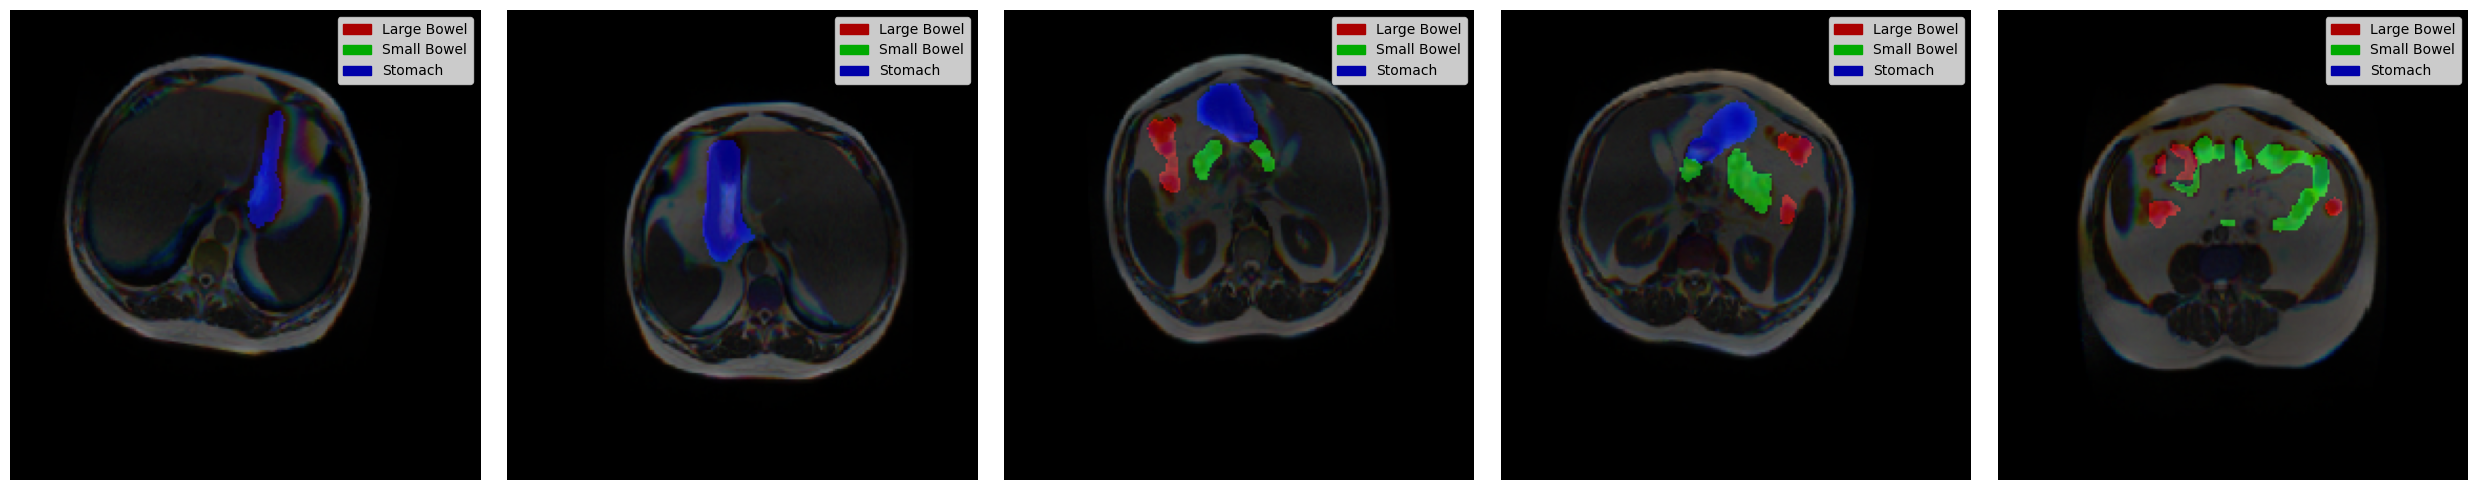

In [23]:
plot_batch(imgs, msks, size=5)

In [24]:
import gc
gc.collect()

12203

In [25]:
### test ###

import argparse
import copy
import logging
import os
import random
import sys
from collections import OrderedDict
# pd.options.plotting.backend = "plotly"
from glob import glob

# Albumentations for augmentations
import albumentations as A
# visualization
import cv2
import matplotlib.pyplot as plt
import ml_collections
import numpy as np
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as Functional
import torch.optim as optim
from matplotlib.patches import Rectangle
from scipy import ndimage
from segmentation_models_pytorch.losses import DiceLoss as smpDL, SoftBCEWithLogitsLoss, TverskyLoss
from tensorboardX import SummaryWriter
from torch.nn import Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.loss import CrossEntropyLoss
from torch.nn.modules.utils import _pair
from torch.utils.data import DataLoader
# PyTorch
from torch.utils.data import Dataset
from tqdm import tqdm



def get_b16_config():
    """Returns the ViT-B/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1

    config.classifier = 'seg'
    config.representation_size = None
    config.resnet_pretrained_path = None
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-B_16.npz'
    config.patch_size = 16

    config.decoder_channels = (256, 128, 64, 16)
    config.n_classes = 2
    config.activation = 'softmax'
    return config


def get_testing():
    """Returns a minimal configuration for testing."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 1
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 1
    config.transformer.num_heads = 1
    config.transformer.num_layers = 1
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None
    return config


def get_r50_b16_config():
    """Returns the Resnet50 + ViT-B/16 configuration."""
    config = get_b16_config()
    config.patches.grid = (16, 16)
    config.resnet = ml_collections.ConfigDict()
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1

    config.classifier = 'seg'
    config.pretrained_path = "https://console.cloud.google.com/storage/browser/_details/vit_models/imagenet21k/R50%2BViT-B_16.npz"
    config.decoder_channels = (256, 128, 64, 16)
    config.skip_channels = [512, 256, 64, 16]
    config.n_classes = 2
    config.n_skip = 3
    config.activation = 'softmax'

    return config


def get_b32_config():
    """Returns the ViT-B/32 configuration."""
    config = get_b16_config()
    config.patches.size = (32, 32)
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-B_32.npz'
    return config


def get_l16_config():
    """Returns the ViT-L/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 1024
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 4096
    config.transformer.num_heads = 16
    config.transformer.num_layers = 24
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.representation_size = None

    # custom
    config.classifier = 'seg'
    config.resnet_pretrained_path = None
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-L_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.n_classes = 2
    config.activation = 'softmax'
    return config


def get_r50_l16_config():
    """Returns the Resnet50 + ViT-L/16 configuration. customized """
    config = get_l16_config()
    config.patches.grid = (16, 16)
    config.resnet = ml_collections.ConfigDict()
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1

    config.classifier = 'seg'
    config.resnet_pretrained_path = '../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.skip_channels = [512, 256, 64, 16]
    config.n_classes = 2
    config.activation = 'softmax'
    return config


def get_l32_config():
    """Returns the ViT-L/32 configuration."""
    config = get_l16_config()
    config.patches.size = (32, 32)
    return config


def get_h14_config():
    """Returns the ViT-L/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (14, 14)})
    config.hidden_size = 1280
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 5120
    config.transformer.num_heads = 16
    config.transformer.num_layers = 32
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None

    return config


class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(),
                                                                                                  target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes


def worker_init_fn(worker_id):
    random.seed(worker_id)


# import math


def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


class StdConv2d(nn.Conv2d):

    def forward(self, x):
        w = self.weight
        # v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
        v = torch.var(w, dim=[1, 2, 3], unbiased=False, keepdim=True)
        m = torch.mean(w, dim=[1, 2, 3], keepdim=True)
        w = (w - m) / torch.sqrt(v + 1e-5)
        return F.conv2d(x, w, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)


def conv3x3(cin, cout, stride=1, groups=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=3, stride=stride,
                     padding=1, bias=bias, groups=groups)


def conv1x1(cin, cout, stride=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=1, stride=stride,
                     padding=0, bias=bias)


class PreActBottleneck(nn.Module):
    """Pre-activation (v2) bottleneck block.
    """

    def __init__(self, cin, cout=None, cmid=None, stride=1):
        super().__init__()
        cout = cout or cin
        cmid = cmid or cout // 4

        self.gn1 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv1 = conv1x1(cin, cmid, bias=False)
        self.gn2 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv2 = conv3x3(cmid, cmid, stride, bias=False)  # Original code has it on conv1!!
        self.gn3 = nn.GroupNorm(32, cout, eps=1e-6)
        self.conv3 = conv1x1(cmid, cout, bias=False)
        self.relu = nn.ReLU(inplace=True)

        if (stride != 1 or cin != cout):
            # Projection also with pre-activation according to paper.
            self.downsample = conv1x1(cin, cout, stride, bias=False)
            self.gn_proj = nn.GroupNorm(cout, cout)

    def forward(self, x):

        # Residual branch
        residual = x
        if hasattr(self, 'downsample'):
            residual = self.downsample(x)
            residual = self.gn_proj(residual)

        # Unit's branch
        y = self.relu(self.gn1(self.conv1(x)))
        y = self.relu(self.gn2(self.conv2(y)))
        y = self.gn3(self.conv3(y))

        y = self.relu(residual + y)
        return y

    def load_from(self, weights, n_block, n_unit):
        conv1_weight = np2th(weights[(n_block + "/" + n_unit + "/" + "conv1/kernel")], conv=True)
        conv2_weight = np2th(weights[(n_block + "/" + n_unit + "/" + "conv2/kernel")], conv=True)
        conv3_weight = np2th(weights[(n_block + "/" + n_unit + "/" + "conv3/kernel")], conv=True)

        gn1_weight = np2th(weights[(n_block + "/" + n_unit + "/" + "gn1/scale")])
        gn1_bias = np2th(weights[(n_block + "/" + n_unit + "/" + "gn1/bias")])

        gn2_weight = np2th(weights[(n_block + "/" + n_unit + "/" + "gn2/scale")])
        gn2_bias = np2th(weights[(n_block + "/" + n_unit + "/" + "gn2/bias")])

        gn3_weight = np2th(weights[(n_block + "/" + n_unit + "/" + "gn3/scale")])
        gn3_bias = np2th(weights[(n_block + "/" + n_unit + "/" + "gn3/bias")])

        self.conv1.weight.copy_(conv1_weight)
        self.conv2.weight.copy_(conv2_weight)
        self.conv3.weight.copy_(conv3_weight)

        self.gn1.weight.copy_(gn1_weight.view(-1))
        self.gn1.bias.copy_(gn1_bias.view(-1))

        self.gn2.weight.copy_(gn2_weight.view(-1))
        self.gn2.bias.copy_(gn2_bias.view(-1))

        self.gn3.weight.copy_(gn3_weight.view(-1))
        self.gn3.bias.copy_(gn3_bias.view(-1))

        if hasattr(self, 'downsample'):
            proj_conv_weight = np2th(weights[(n_block + "/" + n_unit + "/" + "conv_proj/kernel")], conv=True)
            proj_gn_weight = np2th(weights[(n_block + "/" + n_unit + "/" + "gn_proj/scale")])
            proj_gn_bias = np2th(weights[(n_block + "/" + n_unit + "/" + "gn_proj/bias")])

            self.downsample.weight.copy_(proj_conv_weight)
            self.gn_proj.weight.copy_(proj_gn_weight.view(-1))
            self.gn_proj.bias.copy_(proj_gn_bias.view(-1))


class ResNetV2(nn.Module):
    """Implementation of Pre-activation (v2) ResNet mode."""

    def __init__(self, block_units, width_factor):
        super().__init__()
        width = int(64 * width_factor)
        self.width = width

        self.root = nn.Sequential(OrderedDict([
            ('conv', StdConv2d(3, width, kernel_size=7, stride=2, bias=False, padding=3)),
            ('gn', nn.GroupNorm(32, width, eps=1e-6)),
            ('relu', nn.ReLU(inplace=True)),
            # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        ]))

        self.body = nn.Sequential(OrderedDict([
            ('block1', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width, cout=width * 4, cmid=width))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width * 4, cout=width * 4, cmid=width)) for i in
                 range(2, block_units[0] + 1)],
            ))),
            ('block2', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width * 4, cout=width * 8, cmid=width * 2, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width * 8, cout=width * 8, cmid=width * 2)) for i in
                 range(2, block_units[1] + 1)],
            ))),
            ('block3', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width * 8, cout=width * 16, cmid=width * 4, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width * 16, cout=width * 16, cmid=width * 4)) for i in
                 range(2, block_units[2] + 1)],
            ))),
        ]))

    def forward(self, x):
        features = []
        b, c, in_size, _ = x.size()
        x = self.root(x)
        features.append(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)(x)
        for i in range(len(self.body) - 1):
            x = self.body[i](x)
            right_size = int(in_size / 4 / (i + 1))
            if x.size()[2] != right_size:
                pad = right_size - x.size()[2]
                assert 3 > pad > 0, "x {} should {}".format(x.size(), right_size)
                feat = torch.zeros((b, x.size()[1], right_size, right_size), device=x.device)
                feat[:, :, 0:x.size()[2], 0:x.size()[3]] = x[:]
            else:
                feat = x
            features.append(feat)
        x = self.body[-1](x)
        return x, features[::-1]


"""
This version of transunet contains the TUP and BiF block as implemented by me according to the equations in
the paper.
Saved in separate file before transformer decoder integration.

"""
logger = logging.getLogger(__name__)

ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"


def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}


####### TUP ########
class StdConv2d(nn.Conv2d):
    """Standard Convolution with weight normalization."""

    def forward(self, x):
        w = self.weight
        v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
        w = (w - m) / torch.sqrt(v + 1e-5)
        return Functional.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)


class DoubleConv(nn.Module):
    """(convolution(3x3, pad=1) => [BN] => ReLU) * 2
    Currently uses the wrapper above"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            StdConv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            StdConv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class TUP(nn.Module):
    """Transformer UP-sampler.
    Inputs: transformer output features
    Outputs: transformer output features scaled up, in preparation to enter BiFusion block.
    """

    def __init__(self, cin, cout):
        super().__init__()
        cmid = (cin + cout) // 2
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dblConv = DoubleConv(cin, cout, cmid)
        self.conv1 = nn.Sequential(
            StdConv2d(cin, cout, kernel_size=1),
            nn.BatchNorm2d(cout),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Upsample features
        upsampled_x = self.up(x)

        # Residual branch processing
        residual = self.conv1(upsampled_x)

        # Main branch processing
        y = self.dblConv(upsampled_x)

        # Integrate features through element-wise multiplication
        y = y * residual

        return y


####### BiFusion ########
"""
This variant is loyal to the implementation mentioned in the sources provided in BiFTransNet
"""


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class ChannelAttention(nn.Module):
    def __init__(self, input_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.input_channels = input_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        #  uses Convolutions instead of Linear
        self.MLP = nn.Sequential(
            Flatten(),
            nn.Linear(input_channels, input_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(input_channels // reduction_ratio, input_channels)
        )

    def forward(self, x):
        # Take the input and apply average and max pooling
        avg_values = self.avg_pool(x)
        max_values = self.max_pool(x)
        out = self.MLP(avg_values) + self.MLP(max_values)
        scale = x * torch.sigmoid(out).unsqueeze(2).unsqueeze(3).expand_as(x)
        return scale


class AvgSpatial(nn.Module):
    def forward(self, x):
        return Functional.avg_pool2d(x, x.size()[2:])


class TripleConv(nn.Module):
    def __init__(self, num_channels):
        super(TripleConv, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.conv3 = nn.Conv2d(num_channels, num_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(num_channels)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        do_bn = x.size(2) > 1 and x.size(3) > 1  # Check if spatial dimensions are larger than 1x1
        identity = x

        out = self.conv1(x)
        if do_bn:
            out = self.bn1(out)
        out = self.relu1(out)

        out = out + identity  # Skip connection

        out = self.conv2(out)
        if do_bn:  # Check again for spatial dimensions
            out = self.bn2(out)
        out = self.relu2(out)

        out = out + identity  # Another skip connection

        out = self.conv3(out)
        if do_bn:  # Final check for spatial dimensions
            out = self.bn3(out)
        out = self.relu3(out)

        return out


class ConvChannelAttention(nn.Module):
    def __init__(self, num_channels):
        super(ConvChannelAttention, self).__init__()
        self.avg_spatial = AvgSpatial()  # Average spatial pooling
        self.triple_conv = TripleConv(num_channels)  # Triple convolution block
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation

    def forward(self, x):
        out = self.avg_spatial(x)  # Eq. (8)
        out = self.triple_conv(out)  # Eq. (9)
        out = self.sigmoid(out) * x  # Eq. (10)
        return out


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.bn = nn.InstanceNorm2d(1, affine=True)  # in lieu of batchnorm
        # fixes the following error:
        # RuntimeError: Function NativeBatchNormBackward0 returned an invalid gradient at index 1 -
        # got [] but expected shape compatible with [1]

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        out = self.bn(out)
        out = x * torch.sigmoid(out)
        return out


class MultimodalFusion(nn.Module):
    def __init__(self, num_channels):
        super(MultimodalFusion, self).__init__()
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)

    def forward(self, ti, ci):
        # Adjusting to match the paper's description -
        # early version contained a mistake (concatenation instead of Hadamard)
        out = ti * ci  # Element-wise multiplication (Hadamard product)
        out = self.conv(out)  # Apply convolution
        return out


class BiFusion_block(nn.Module):
    def __init__(self, num_channels, use_conv_channel_att=True):
        super(BiFusion_block, self).__init__()
        if use_conv_channel_att:
            print("Initialized conv channel attention!")
            self.ca = ConvChannelAttention(num_channels)
        else:
            self.ca = ChannelAttention(num_channels)  # Channel Attention
        self.sa = SpatialAttention()  # Spatial Attention
        self.fusion = MultimodalFusion(num_channels)  # Multimodal Fusion
        self.residual = nn.Sequential(
            nn.Conv2d(num_channels * 3, num_channels, kernel_size=1),  # Residual connection
            nn.BatchNorm2d(num_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, ti, ci):
        t3 = self.ca(ti)  # Output of Channel Attention
        c5 = self.sa(ci)  # Output of Spatial Attention
        fi = self.fusion(ti, ci)  # Output of Multimodal Fusion
        out = torch.cat([t3, c5, fi], dim=1)  # Concatenate outputs
        out = self.residual(out)  # Pass through residual module
        return out


### ### ###


class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / (self.attention_head_size ** (1 / 2))
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config.transformer["dropout_rate"])

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """

    def __init__(self, config, img_size, in_channels=3):
        super(Embeddings, self).__init__()
        self.hybrid = None
        self.config = config
        img_size = _pair(img_size)

        if config.patches.get("grid") is not None:  # ResNet
            grid_size = config.patches["grid"]
            patch_size = (img_size[0] // 16 // grid_size[0], img_size[1] // 16 // grid_size[1])
            patch_size_real = (patch_size[0] * 16, patch_size[1] * 16)
            n_patches = (img_size[0] // patch_size_real[0]) * (img_size[1] // patch_size_real[1])
            self.hybrid = True
        else:
            patch_size = _pair(config.patches["size"])
            n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
            self.hybrid = False

        if self.hybrid:
            self.hybrid_model = ResNetV2(block_units=config.resnet.num_layers, width_factor=config.resnet.width_factor)
            in_channels = self.hybrid_model.width * 16
        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches, config.hidden_size))

        self.dropout = Dropout(config.transformer["dropout_rate"])

    def forward(self, x):
        if self.hybrid:
            x, features = self.hybrid_model(x)
        else:
            features = None
        x = self.patch_embeddings(x)  # (B, hidden. n_patches^(1/2), n_patches^(1/2))
        x = x.flatten(2)
        x = x.transpose(-1, -2)  # (B, n_patches, hidden)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings, features


class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

    def load_from(self, weights, n_block):
        ROOT = f"Transformer/encoderblock_{n_block}"
        with torch.no_grad():
            query_weight = np2th(weights[(ROOT + "/" + ATTENTION_Q + "/" + "kernel.npy")]).view(self.hidden_size,
                                                                                                self.hidden_size).t()
            key_weight = np2th(weights[(ROOT + "/" + ATTENTION_K + "/" + "kernel.npy")]).view(self.hidden_size,
                                                                                              self.hidden_size).t()
            value_weight = np2th(weights[(ROOT + "/" + ATTENTION_V + "/" + "kernel.npy")]).view(self.hidden_size,
                                                                                                self.hidden_size).t()
            out_weight = np2th(weights[(ROOT + "/" + ATTENTION_OUT + "/" + "kernel.npy")]).view(self.hidden_size,
                                                                                                self.hidden_size).t()

            query_bias = np2th(weights[(ROOT + "/" + ATTENTION_Q + "/" + "bias.npy")]).view(-1)
            key_bias = np2th(weights[(ROOT + "/" + ATTENTION_K + "/" + "bias.npy")]).view(-1)
            value_bias = np2th(weights[(ROOT + "/" + ATTENTION_V + "/" + "bias.npy")]).view(-1)
            out_bias = np2th(weights[(ROOT + "/" + ATTENTION_OUT + "/" + "bias.npy")]).view(-1)

            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)

            mlp_weight_0 = np2th(weights[(ROOT + "/" + FC_0 + "/" + "kernel.npy")]).t()
            mlp_weight_1 = np2th(weights[(ROOT + "/" + FC_1 + "/" + "kernel.npy")]).t()
            mlp_bias_0 = np2th(weights[(ROOT + "/" + FC_0 + "/" + "bias.npy")]).t()
            mlp_bias_1 = np2th(weights[(ROOT + "/" + FC_1 + "/" + "bias.npy")]).t()

            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)

            self.attention_norm.weight.copy_(np2th(weights[(ROOT + "/" + ATTENTION_NORM + "/" + "scale.npy")]))
            self.attention_norm.bias.copy_(np2th(weights[(ROOT + "/" + ATTENTION_NORM + "/" + "bias.npy")]))
            self.ffn_norm.weight.copy_(np2th(weights[(ROOT + "/" + MLP_NORM + "/" + "scale.npy")]))
            self.ffn_norm.bias.copy_(np2th(weights[(ROOT + "/" + MLP_NORM + "/" + "bias.npy")]))


class Encoder(nn.Module):
    def __init__(self, config, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights


class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output, features = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)  # (B, n_patch, hidden)
        return encoded, attn_weights, features


class Conv2dReLU(nn.Sequential):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            stride=1,
            use_batchnorm=True,
    ):
        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not use_batchnorm,
        )
        relu = nn.ReLU(inplace=True)

        bn = nn.BatchNorm2d(out_channels)

        super(Conv2dReLU, self).__init__(conv, bn, relu)


class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            skip_channels=0,
            residual_channels=0,
            use_batchnorm=True,
            use_bi_fusion=True,
            use_multiscale=False,
            reduction_factor=8,  # attempt to reduce overfitting by reducing channel dimensions of multiscale skips
    ):
        super().__init__()
        """
        BiF block here!
        The bif block is a per-tier block - instead of in-channels + skip-channels as inputs,
        we want to get in-channels + BiFusion output channels.
        Also,
        """
        self.use_bi_fusion = False
        self.use_multiscale = False
        if use_bi_fusion and skip_channels:
            self.use_bi_fusion = True
            self.bifusion = BiFusion_block(skip_channels)
        if use_multiscale and residual_channels:

            self.use_multiscale = True
            self.reduce_conv = Conv2dReLU(residual_channels, residual_channels // reduction_factor, 3, 1)
            self.up_res = nn.UpsamplingBilinear2d(scale_factor=4)  # prep size of residual input


        self.conv1 = Conv2dReLU(
            in_channels + skip_channels + residual_channels // reduction_factor,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x, skip=None, tup_out=None, res_in=None):
        # print(f"{x.shape=}")
        # if skip is not None:
        #     print(f"{skip.shape=}")
        # if tup_out is not None:
        #     print(f"{tup_out.shape=}")
        # if res_in is not None:
        #     print(f"{res_in.shape=}")
        # first concatenate residual output to X

        x = self.up(x)
        if skip is not None:

            """
            Forward pass addition of the BiF block
            """
            if self.use_bi_fusion and tup_out is not None:
                assert skip.shape == tup_out.shape
                skip = self.bifusion(skip, tup_out)
            x = torch.cat([x, skip], dim=1)

        if self.use_multiscale and res_in is not None:
            # residual skip inserted here:
            res_in = self.reduce_conv(res_in)  # reduce channel count
            res_in = self.up_res(res_in)  # fit dimensions
            x = torch.cat((x, res_in), dim=1)
            # Apply LayerNorm to residual connection

        # regular U-Net decoder block:
        x = self.conv1(x)
        x = self.conv2(x)
        # print(f'fOutput shape={x.shape}\n')
        return x



class SegmentationHead(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size=3, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        super().__init__(conv2d, upsampling)


class DecoderCup(nn.Module):
    def __init__(self, config, multiscale=False):
        super().__init__()
        self.config = config
        head_channels = 512
        self.conv_more = Conv2dReLU(
            config.hidden_size,
            head_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=True,
        )
        self.multiscale = multiscale
        decoder_channels = config.decoder_channels
        in_channels = [head_channels] + list(decoder_channels[:-1])
        out_channels = decoder_channels
        """
        Insert TUP here - each skip connection input to a decoder block needs a dedicated TUP component
        """
        if self.config.n_skip != 0:
            skip_channels = self.config.skip_channels
            for i in range(4 - self.config.n_skip):  # re-select the skip channels according to n_skip
                skip_channels[3 - i] = 0

        else:
            skip_channels = [0, 0, 0, 0]
        if self.multiscale:
            blocks = [
                DecoderBlock(in_ch, out_ch, sk_ch, 2*in_ch if (i > 0 and sk_ch > 0) else 0,
                             use_multiscale=True if (i > 0 and sk_ch > 0) else False)
                for i, (in_ch, out_ch, sk_ch) in
                enumerate(zip(in_channels, out_channels, skip_channels))
            ]
        else:
            blocks = [
                DecoderBlock(in_ch, out_ch, sk_ch) for in_ch, out_ch, sk_ch in
                zip(in_channels, out_channels, skip_channels)
            ]
        tup_blocks = None
        if skip_channels:
            tup_blocks = []
            # first tup - take head and set it to skip connection size
            last_tup_input_size = head_channels
            for idx in range(len(skip_channels)):

                if skip_channels[idx]:  # we actually use this skip channel
                    # then create a tup block and set input=last tup output and output = skip channel size
                    # print(f"{skip_channels[idx]=}, {idx=}, {last_tup_input_size=}")
                    tup_blocks.append(TUP(last_tup_input_size, skip_channels[idx]))
                    last_tup_input_size = skip_channels[idx]

        self.blocks = nn.ModuleList(blocks)
        if tup_blocks is not None:
            # define TUP blocks modules
            self.TUP_blocks = nn.ModuleList(tup_blocks)

    def forward(self, hidden_states, features=None):
        out_features = []
        B, n_patch, hidden = hidden_states.size()  # reshape from (B, n_patch, hidden) to (B, h, w, hidden)
        h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))
        x = hidden_states.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, h, w)
        x = self.conv_more(x)  # x is now basically the transformer output
        tup_out = x  # save the original state of transformer embeddings
        tup_idx = 0
        before_last = None
        last = x
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.config.n_skip) else None
                if tup_idx < len(self.TUP_blocks):
                    # use TUP:
                    tup_out = self.TUP_blocks[tup_idx](tup_out)
                    tup_idx += 1
            else:
                skip = None
            x = decoder_block(x, skip=skip, tup_out=tup_out, res_in = before_last if self.multiscale and (last is not None) else None)
            before_last = last
            last = x
        return x



class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False, multiscale=True):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier
        self.transformer = Transformer(config, img_size, vis)
        if multiscale:
            print("Model initialized WITH multiscale skip connection component!")
        self.decoder = DecoderCup(config, multiscale=multiscale)
        self.segmentation_head = SegmentationHead(
            in_channels=config['decoder_channels'][-1],
            out_channels=config['n_classes'],
            kernel_size=3,
        )
        self.config = config


    def forward(self, x):
        if x.size()[1] == 1:
            x = x.repeat(1, 3, 1, 1)  # "convert" a 1D image to 3D (if input is 1D)
        x, attn_weights, features = self.transformer(x)  # (B, n_patch, hidden)
        x = self.decoder(x, features)
        logits = self.segmentation_head(x)
        return logits

    def load_from(self, weights):

        with torch.no_grad():

            res_weight = weights
            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel.npy"], conv=True))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias.npy"]))
            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale.npy"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias.npy"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding.npy"])

            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            elif posemb.size()[1] - 1 == posemb_new.size()[1]:
                posemb = posemb[:, 1:]
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                logger.info("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)
                if self.classifier == "seg":
                    _, posemb_grid = posemb[:, :1], posemb[0, 1:]
                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)
                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)  # th2np
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = posemb_grid
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            # Encoder whole
            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

            if self.transformer.embeddings.hybrid:
                self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(
                    np2th(res_weight["conv_root/kernel.npy"], conv=True))
                gn_weight = np2th(res_weight["gn_root/scale.npy"]).view(-1)
                gn_bias = np2th(res_weight["gn_root/bias.npy"]).view(-1)
                self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
                self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

                for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
                    for uname, unit in block.named_children():
                        unit.load_from(res_weight, n_block=bname, n_unit=uname)


CONFIGS = {
    'ViT-B_16': get_b16_config(),
    'ViT-B_32': get_b32_config(),
    'ViT-L_16': get_l16_config(),
    'ViT-L_32': get_l32_config(),
    'ViT-H_14': get_h14_config(),
    'R50-ViT-B_16': get_r50_b16_config(),
    'R50-ViT-L_16': get_r50_l16_config(),
    'testing': get_testing(),
}


### end test ###

# 📦 Model


In [26]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    config_vit = CONFIGS['R50-ViT-B_16']
    config_vit.n_classes = CFG.num_classes
    config_vit.n_skip = 3
    config_vit.patches.grid = (
        # this is supposed to be ImageSizeW / vit-patch-size, ImageSizeH / vit-patch-size, but I can't
        int(224 / 16), int(224 / 16))
    model = VisionTransformer(config_vit, img_size=224, num_classes=CFG.num_classes)
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# 🔧 Loss Function

In [27]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False, gamma=1.1)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def hausdorff_distance(y_true, y_pred):
  # TODO: test this
  yt = y_true.cpu().detach().numpy()
  yp = y_pred.cpu().detach().numpy()
  return skimage.metrics.hausdorff_distance(yt, yp, method='standard')


def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

# 🚄 Training Function

In [28]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()

    dataset_size = 0
    running_loss = 0.0

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)

        batch_size = images.size(0)

        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate

        scaler.scale(loss).backward()

        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
        torch.cuda.empty_cache()
        gc.collect()

    return epoch_loss

# 👀 Validation Function

In [29]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0

    val_scores = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)

        batch_size = images.size(0)

        y_pred  = model(images)
        loss    = criterion(y_pred, masks)

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_hausdorff = 0 #hausdorff_distance(masks, y_pred)
        val_scores.append([val_dice, val_jaccard, val_hausdorff])

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, val_scores

# 🏃 Run Training

In [30]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)

    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler,
                                           dataloader=train_loader,
                                           device=CFG.device, epoch=epoch)

        val_loss, val_scores = valid_one_epoch(model, valid_loader,
                                                 device=CFG.device,
                                                 epoch=epoch)
        val_dice, val_jaccard, val_hausdorff = val_scores

        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)

        # Log the metrics
        wandb.log({"Train Loss": train_loss,
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Jaccard": val_jaccard,
                   "LR":scheduler.get_last_lr()[0]})

        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f} | Valid hausdorff: {val_hausdorff:0.4f}')

        # deep copy the model
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            run.summary["Best Dice"]    = best_dice
            run.summary["Best Jaccard"] = best_jaccard
            run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            wandb.save(PATH)
            print(f"Model Saved{sr_}")

            PATH = gdrive_path + f"best_epoch_weights_muti-scale_attempt_so-far.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model saved to drive!")



        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)


        print(); print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

# 🔍 Optimizer

<img src="https://mlfromscratch.com/content/images/2019/12/saddle.gif" width=500>

In [31]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max,
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0,
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None

    return scheduler

In [32]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 41.0MB/s]


Model initialized WITH multiscale skip connection component!
Initialized conv channel attention!
Initialized conv channel attention!
Initialized conv channel attention!


# 🚅 Training

In [ ]:
for fold in CFG.folds:
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='uw-maddison-gi-tract',
                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                     anonymous=anonymous,
                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                     group=CFG.comment,
                    )
    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG.debug)
    model     = build_model()
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

###############
### Fold: 0
###############


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Model initialized WITH multiscale skip connection component!
Initialized conv channel attention!
Initialized conv channel attention!
Initialized conv channel attention!
cuda: NVIDIA A100-SXM4-40GB

Epoch 1/140

Valid : 100%|██████████| 64/64 [00:48<00:00,  1.33it/s, gpu_memory=17.43 GB, lr=0.00200, valid_loss=0.3377]


Valid Dice: 0.6359 | Valid Jaccard: 0.6002 | Valid hausdorff: 0.0000
Valid Score Improved (-inf ---> 0.6359)
Model Saved
Model saved to drive!


Epoch 2/140

Valid : 100%|██████████| 64/64 [00:47<00:00,  1.35it/s, gpu_memory=17.67 GB, lr=0.00200, valid_loss=0.2173]


Valid Dice: 0.7787 | Valid Jaccard: 0.7431 | Valid hausdorff: 0.0000
Valid Score Improved (0.6359 ---> 0.7787)
Model Saved
Model saved to drive!


Epoch 3/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.75 GB, lr=0.00200, valid_loss=0.2051]


Valid Dice: 0.8377 | Valid Jaccard: 0.8070 | Valid hausdorff: 0.0000
Valid Score Improved (0.7787 ---> 0.8377)
Model Saved
Model saved to drive!


Epoch 4/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.98 GB, lr=0.00200, valid_loss=0.1712]


Valid Dice: 0.8500 | Valid Jaccard: 0.8159 | Valid hausdorff: 0.0000
Valid Score Improved (0.8377 ---> 0.8500)
Model Saved
Model saved to drive!


Epoch 5/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.73 GB, lr=0.00199, valid_loss=0.1583]


Valid Dice: 0.8426 | Valid Jaccard: 0.8080 | Valid hausdorff: 0.0000


Epoch 6/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.78 GB, lr=0.00199, valid_loss=0.1593]


Valid Dice: 0.8241 | Valid Jaccard: 0.7902 | Valid hausdorff: 0.0000


Epoch 7/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.74 GB, lr=0.00199, valid_loss=0.1642]


Valid Dice: 0.8643 | Valid Jaccard: 0.8334 | Valid hausdorff: 0.0000
Valid Score Improved (0.8500 ---> 0.8643)
Model Saved
Model saved to drive!


Epoch 8/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.80 GB, lr=0.00198, valid_loss=0.1435]


Valid Dice: 0.8741 | Valid Jaccard: 0.8419 | Valid hausdorff: 0.0000
Valid Score Improved (0.8643 ---> 0.8741)
Model Saved
Model saved to drive!


Epoch 9/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.00 GB, lr=0.00198, valid_loss=0.1713]


Valid Dice: 0.8667 | Valid Jaccard: 0.8372 | Valid hausdorff: 0.0000


Epoch 10/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.79 GB, lr=0.00197, valid_loss=0.1839]


Valid Dice: 0.8644 | Valid Jaccard: 0.8353 | Valid hausdorff: 0.0000


Epoch 11/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.02 GB, lr=0.00197, valid_loss=0.1348]


Valid Dice: 0.8790 | Valid Jaccard: 0.8470 | Valid hausdorff: 0.0000
Valid Score Improved (0.8741 ---> 0.8790)
Model Saved
Model saved to drive!


Epoch 12/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.82 GB, lr=0.00196, valid_loss=0.1346]


Valid Dice: 0.8755 | Valid Jaccard: 0.8444 | Valid hausdorff: 0.0000


Epoch 13/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.84 GB, lr=0.00196, valid_loss=0.1467]


Valid Dice: 0.8657 | Valid Jaccard: 0.8345 | Valid hausdorff: 0.0000


Epoch 14/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.85 GB, lr=0.00195, valid_loss=0.1377]


Valid Dice: 0.8812 | Valid Jaccard: 0.8500 | Valid hausdorff: 0.0000
Valid Score Improved (0.8790 ---> 0.8812)
Model Saved
Model saved to drive!


Epoch 15/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00194, valid_loss=0.1714]


Valid Dice: 0.8694 | Valid Jaccard: 0.8400 | Valid hausdorff: 0.0000


Epoch 16/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.05 GB, lr=0.00194, valid_loss=0.1485]


Valid Dice: 0.8391 | Valid Jaccard: 0.8057 | Valid hausdorff: 0.0000


Epoch 17/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.89 GB, lr=0.00193, valid_loss=0.1310]


Valid Dice: 0.8870 | Valid Jaccard: 0.8562 | Valid hausdorff: 0.0000
Valid Score Improved (0.8812 ---> 0.8870)
Model Saved
Model saved to drive!


Epoch 18/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.05 GB, lr=0.00192, valid_loss=0.1309]


Valid Dice: 0.8743 | Valid Jaccard: 0.8433 | Valid hausdorff: 0.0000


Epoch 19/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.87 GB, lr=0.00191, valid_loss=0.4054]


Valid Dice: 0.7669 | Valid Jaccard: 0.7531 | Valid hausdorff: 0.0000


Epoch 20/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.05 GB, lr=0.00190, valid_loss=0.1295]


Valid Dice: 0.8791 | Valid Jaccard: 0.8480 | Valid hausdorff: 0.0000


Epoch 21/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.99 GB, lr=0.00189, valid_loss=0.1246]


Valid Dice: 0.8867 | Valid Jaccard: 0.8561 | Valid hausdorff: 0.0000


Epoch 22/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00188, valid_loss=0.1349]


Valid Dice: 0.8869 | Valid Jaccard: 0.8574 | Valid hausdorff: 0.0000


Epoch 23/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.90 GB, lr=0.00187, valid_loss=0.1200]


Valid Dice: 0.8853 | Valid Jaccard: 0.8543 | Valid hausdorff: 0.0000


Epoch 24/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00186, valid_loss=0.1404]


Valid Dice: 0.8873 | Valid Jaccard: 0.8573 | Valid hausdorff: 0.0000
Valid Score Improved (0.8870 ---> 0.8873)
Model Saved
Model saved to drive!


Epoch 25/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.90 GB, lr=0.00185, valid_loss=0.1254]


Valid Dice: 0.8902 | Valid Jaccard: 0.8599 | Valid hausdorff: 0.0000
Valid Score Improved (0.8873 ---> 0.8902)
Model Saved
Model saved to drive!


Epoch 26/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.87 GB, lr=0.00183, valid_loss=0.1313]


Valid Dice: 0.8777 | Valid Jaccard: 0.8475 | Valid hausdorff: 0.0000


Epoch 27/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00182, valid_loss=0.3041]


Valid Dice: 0.8084 | Valid Jaccard: 0.7875 | Valid hausdorff: 0.0000


Epoch 28/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.97 GB, lr=0.00181, valid_loss=0.1297]


Valid Dice: 0.8879 | Valid Jaccard: 0.8581 | Valid hausdorff: 0.0000


Epoch 29/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00179, valid_loss=0.1232]


Valid Dice: 0.8793 | Valid Jaccard: 0.8478 | Valid hausdorff: 0.0000


Epoch 30/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.87 GB, lr=0.00178, valid_loss=0.1213]


Valid Dice: 0.8923 | Valid Jaccard: 0.8620 | Valid hausdorff: 0.0000
Valid Score Improved (0.8902 ---> 0.8923)
Model Saved
Model saved to drive!


Epoch 31/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00177, valid_loss=0.1467]


Valid Dice: 0.8789 | Valid Jaccard: 0.8491 | Valid hausdorff: 0.0000


Epoch 32/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.90 GB, lr=0.00175, valid_loss=0.1216]


Valid Dice: 0.8884 | Valid Jaccard: 0.8577 | Valid hausdorff: 0.0000


Epoch 33/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00174, valid_loss=0.1178]


Valid Dice: 0.8944 | Valid Jaccard: 0.8632 | Valid hausdorff: 0.0000
Valid Score Improved (0.8923 ---> 0.8944)
Model Saved
Model saved to drive!


Epoch 34/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.90 GB, lr=0.00172, valid_loss=0.1237]


Valid Dice: 0.8918 | Valid Jaccard: 0.8620 | Valid hausdorff: 0.0000


Epoch 35/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.87 GB, lr=0.00171, valid_loss=0.1182]


Valid Dice: 0.8913 | Valid Jaccard: 0.8608 | Valid hausdorff: 0.0000


Epoch 36/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.90 GB, lr=0.00169, valid_loss=0.1322]


Valid Dice: 0.8866 | Valid Jaccard: 0.8569 | Valid hausdorff: 0.0000


Epoch 37/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.87 GB, lr=0.00167, valid_loss=0.1352]


Valid Dice: 0.8865 | Valid Jaccard: 0.8577 | Valid hausdorff: 0.0000


Epoch 38/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.90 GB, lr=0.00166, valid_loss=0.1232]


Valid Dice: 0.8853 | Valid Jaccard: 0.8551 | Valid hausdorff: 0.0000


Epoch 39/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.87 GB, lr=0.00164, valid_loss=0.1269]


Valid Dice: 0.8619 | Valid Jaccard: 0.8304 | Valid hausdorff: 0.0000


Epoch 40/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.90 GB, lr=0.00162, valid_loss=0.1260]


Valid Dice: 0.8768 | Valid Jaccard: 0.8459 | Valid hausdorff: 0.0000


Epoch 41/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.87 GB, lr=0.00160, valid_loss=0.1241]


Valid Dice: 0.8788 | Valid Jaccard: 0.8478 | Valid hausdorff: 0.0000


Epoch 42/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.90 GB, lr=0.00158, valid_loss=0.1323]


Valid Dice: 0.8771 | Valid Jaccard: 0.8481 | Valid hausdorff: 0.0000


Epoch 43/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.87 GB, lr=0.00157, valid_loss=0.1215]


Valid Dice: 0.8828 | Valid Jaccard: 0.8526 | Valid hausdorff: 0.0000


Epoch 44/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.90 GB, lr=0.00155, valid_loss=0.1290]


Valid Dice: 0.8917 | Valid Jaccard: 0.8624 | Valid hausdorff: 0.0000


Epoch 45/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.87 GB, lr=0.00153, valid_loss=0.1243]


Valid Dice: 0.8937 | Valid Jaccard: 0.8641 | Valid hausdorff: 0.0000


Epoch 46/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.90 GB, lr=0.00151, valid_loss=0.1252]


Valid Dice: 0.8963 | Valid Jaccard: 0.8677 | Valid hausdorff: 0.0000
Valid Score Improved (0.8944 ---> 0.8963)
Model Saved
Model saved to drive!


Epoch 47/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.87 GB, lr=0.00149, valid_loss=0.1245]


Valid Dice: 0.8912 | Valid Jaccard: 0.8613 | Valid hausdorff: 0.0000


Epoch 48/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00147, valid_loss=0.1306]


Valid Dice: 0.8888 | Valid Jaccard: 0.8599 | Valid hausdorff: 0.0000


Epoch 49/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00145, valid_loss=0.1238]


Valid Dice: 0.8708 | Valid Jaccard: 0.8406 | Valid hausdorff: 0.0000


Epoch 50/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00143, valid_loss=0.1199]


Valid Dice: 0.8944 | Valid Jaccard: 0.8644 | Valid hausdorff: 0.0000


Epoch 51/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00141, valid_loss=0.1220]


Valid Dice: 0.8874 | Valid Jaccard: 0.8581 | Valid hausdorff: 0.0000


Epoch 52/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00139, valid_loss=0.1178]


Valid Dice: 0.8916 | Valid Jaccard: 0.8615 | Valid hausdorff: 0.0000


Epoch 53/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00137, valid_loss=0.1230]


Valid Dice: 0.8875 | Valid Jaccard: 0.8571 | Valid hausdorff: 0.0000


Epoch 54/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00135, valid_loss=0.1319]


Valid Dice: 0.8910 | Valid Jaccard: 0.8615 | Valid hausdorff: 0.0000


Epoch 55/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00133, valid_loss=0.1171]


Valid Dice: 0.8916 | Valid Jaccard: 0.8613 | Valid hausdorff: 0.0000


Epoch 56/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00130, valid_loss=0.1243]


Valid Dice: 0.8914 | Valid Jaccard: 0.8609 | Valid hausdorff: 0.0000


Epoch 57/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00128, valid_loss=0.1175]


Valid Dice: 0.8872 | Valid Jaccard: 0.8567 | Valid hausdorff: 0.0000


Epoch 58/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00126, valid_loss=0.1285]


Valid Dice: 0.8818 | Valid Jaccard: 0.8516 | Valid hausdorff: 0.0000


Epoch 59/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00124, valid_loss=0.1193]


Valid Dice: 0.8930 | Valid Jaccard: 0.8627 | Valid hausdorff: 0.0000


Epoch 60/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00122, valid_loss=0.1278]


Valid Dice: 0.8953 | Valid Jaccard: 0.8669 | Valid hausdorff: 0.0000


Epoch 61/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00120, valid_loss=0.1306]


Valid Dice: 0.8877 | Valid Jaccard: 0.8572 | Valid hausdorff: 0.0000


Epoch 62/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00117, valid_loss=0.1217]


Valid Dice: 0.8898 | Valid Jaccard: 0.8593 | Valid hausdorff: 0.0000


Epoch 63/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00115, valid_loss=0.1397]


Valid Dice: 0.8736 | Valid Jaccard: 0.8420 | Valid hausdorff: 0.0000


Epoch 64/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.06 GB, lr=0.00113, valid_loss=0.1463]


Valid Dice: 0.8825 | Valid Jaccard: 0.8557 | Valid hausdorff: 0.0000


Epoch 65/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00111, valid_loss=0.1276]


Valid Dice: 0.8778 | Valid Jaccard: 0.8478 | Valid hausdorff: 0.0000


Epoch 66/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00108, valid_loss=0.1151]


Valid Dice: 0.9006 | Valid Jaccard: 0.8710 | Valid hausdorff: 0.0000
Valid Score Improved (0.8963 ---> 0.9006)
Model Saved
Model saved to drive!


Epoch 67/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00106, valid_loss=0.1186]


Valid Dice: 0.8785 | Valid Jaccard: 0.8477 | Valid hausdorff: 0.0000


Epoch 68/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.90 GB, lr=0.00104, valid_loss=0.1169]


Valid Dice: 0.8832 | Valid Jaccard: 0.8531 | Valid hausdorff: 0.0000


Epoch 69/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00102, valid_loss=0.1207]


Valid Dice: 0.8913 | Valid Jaccard: 0.8611 | Valid hausdorff: 0.0000


Epoch 70/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.92 GB, lr=0.00099, valid_loss=0.1224]


Valid Dice: 0.8932 | Valid Jaccard: 0.8644 | Valid hausdorff: 0.0000


Epoch 71/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00097, valid_loss=0.1242]


Valid Dice: 0.8943 | Valid Jaccard: 0.8654 | Valid hausdorff: 0.0000


Epoch 72/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.92 GB, lr=0.00095, valid_loss=0.1169]


Valid Dice: 0.8960 | Valid Jaccard: 0.8659 | Valid hausdorff: 0.0000


Epoch 73/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00093, valid_loss=0.1208]


Valid Dice: 0.8933 | Valid Jaccard: 0.8631 | Valid hausdorff: 0.0000


Epoch 74/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.90 GB, lr=0.00090, valid_loss=0.1150]


Valid Dice: 0.8889 | Valid Jaccard: 0.8590 | Valid hausdorff: 0.0000


Epoch 75/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.87 GB, lr=0.00088, valid_loss=0.1223]


Valid Dice: 0.8911 | Valid Jaccard: 0.8617 | Valid hausdorff: 0.0000


Epoch 76/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.91 GB, lr=0.00086, valid_loss=0.1185]


Valid Dice: 0.8981 | Valid Jaccard: 0.8688 | Valid hausdorff: 0.0000


Epoch 77/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00084, valid_loss=0.1174]


Valid Dice: 0.8864 | Valid Jaccard: 0.8563 | Valid hausdorff: 0.0000


Epoch 78/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.92 GB, lr=0.00082, valid_loss=0.1196]


Valid Dice: 0.8869 | Valid Jaccard: 0.8562 | Valid hausdorff: 0.0000


Epoch 79/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00079, valid_loss=0.1170]


Valid Dice: 0.8931 | Valid Jaccard: 0.8629 | Valid hausdorff: 0.0000


Epoch 80/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.91 GB, lr=0.00077, valid_loss=0.1227]


Valid Dice: 0.8872 | Valid Jaccard: 0.8567 | Valid hausdorff: 0.0000


Epoch 81/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00075, valid_loss=0.1199]


Valid Dice: 0.8935 | Valid Jaccard: 0.8641 | Valid hausdorff: 0.0000


Epoch 82/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.91 GB, lr=0.00073, valid_loss=0.1164]


Valid Dice: 0.8997 | Valid Jaccard: 0.8706 | Valid hausdorff: 0.0000


Epoch 83/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00071, valid_loss=0.1202]


Valid Dice: 0.8970 | Valid Jaccard: 0.8676 | Valid hausdorff: 0.0000


Epoch 84/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.91 GB, lr=0.00068, valid_loss=0.1198]


Valid Dice: 0.8904 | Valid Jaccard: 0.8605 | Valid hausdorff: 0.0000


Epoch 85/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00066, valid_loss=0.1184]


Valid Dice: 0.8978 | Valid Jaccard: 0.8685 | Valid hausdorff: 0.0000


Epoch 86/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.91 GB, lr=0.00064, valid_loss=0.1190]


Valid Dice: 0.8966 | Valid Jaccard: 0.8667 | Valid hausdorff: 0.0000


Epoch 87/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00062, valid_loss=0.1205]


Valid Dice: 0.8977 | Valid Jaccard: 0.8687 | Valid hausdorff: 0.0000


Epoch 88/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.90 GB, lr=0.00060, valid_loss=0.1173]


Valid Dice: 0.9023 | Valid Jaccard: 0.8731 | Valid hausdorff: 0.0000
Valid Score Improved (0.9006 ---> 0.9023)
Model Saved
Model saved to drive!


Epoch 89/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00058, valid_loss=0.1169]


Valid Dice: 0.8930 | Valid Jaccard: 0.8630 | Valid hausdorff: 0.0000


Epoch 90/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00056, valid_loss=0.1167]


Valid Dice: 0.8969 | Valid Jaccard: 0.8673 | Valid hausdorff: 0.0000


Epoch 91/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00054, valid_loss=0.1193]


Valid Dice: 0.9010 | Valid Jaccard: 0.8724 | Valid hausdorff: 0.0000


Epoch 92/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00052, valid_loss=0.1263]


Valid Dice: 0.8997 | Valid Jaccard: 0.8716 | Valid hausdorff: 0.0000


Epoch 93/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00050, valid_loss=0.1154]


Valid Dice: 0.9022 | Valid Jaccard: 0.8731 | Valid hausdorff: 0.0000


Epoch 94/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00048, valid_loss=0.1157]


Valid Dice: 0.9050 | Valid Jaccard: 0.8759 | Valid hausdorff: 0.0000
Valid Score Improved (0.9023 ---> 0.9050)
Model Saved
Model saved to drive!


Epoch 95/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00046, valid_loss=0.1145]


Valid Dice: 0.8949 | Valid Jaccard: 0.8654 | Valid hausdorff: 0.0000


Epoch 96/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.91 GB, lr=0.00044, valid_loss=0.1127]


Valid Dice: 0.9015 | Valid Jaccard: 0.8724 | Valid hausdorff: 0.0000


Epoch 97/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00042, valid_loss=0.1153]


Valid Dice: 0.9021 | Valid Jaccard: 0.8728 | Valid hausdorff: 0.0000


Epoch 98/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.90 GB, lr=0.00041, valid_loss=0.1120]


Valid Dice: 0.9056 | Valid Jaccard: 0.8766 | Valid hausdorff: 0.0000
Valid Score Improved (0.9050 ---> 0.9056)
Model Saved
Model saved to drive!


Epoch 99/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00039, valid_loss=0.1145]


Valid Dice: 0.9044 | Valid Jaccard: 0.8757 | Valid hausdorff: 0.0000


Epoch 100/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00037, valid_loss=0.1202]


Valid Dice: 0.9001 | Valid Jaccard: 0.8709 | Valid hausdorff: 0.0000


Epoch 101/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00035, valid_loss=0.1143]


Valid Dice: 0.9002 | Valid Jaccard: 0.8705 | Valid hausdorff: 0.0000


Epoch 102/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00034, valid_loss=0.1141]


Valid Dice: 0.8993 | Valid Jaccard: 0.8701 | Valid hausdorff: 0.0000


Epoch 103/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00032, valid_loss=0.1140]


Valid Dice: 0.9033 | Valid Jaccard: 0.8741 | Valid hausdorff: 0.0000


Epoch 104/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00030, valid_loss=0.1100]


Valid Dice: 0.9001 | Valid Jaccard: 0.8706 | Valid hausdorff: 0.0000


Epoch 105/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00029, valid_loss=0.1127]


Valid Dice: 0.8977 | Valid Jaccard: 0.8680 | Valid hausdorff: 0.0000


Epoch 106/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00027, valid_loss=0.1125]


Valid Dice: 0.8986 | Valid Jaccard: 0.8690 | Valid hausdorff: 0.0000


Epoch 107/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00026, valid_loss=0.1109]


Valid Dice: 0.9017 | Valid Jaccard: 0.8723 | Valid hausdorff: 0.0000


Epoch 108/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00024, valid_loss=0.1164]


Valid Dice: 0.9029 | Valid Jaccard: 0.8742 | Valid hausdorff: 0.0000


Epoch 109/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00023, valid_loss=0.1150]


Valid Dice: 0.9025 | Valid Jaccard: 0.8737 | Valid hausdorff: 0.0000


Epoch 110/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.37it/s, gpu_memory=18.07 GB, lr=0.00021, valid_loss=0.1172]


Valid Dice: 0.8992 | Valid Jaccard: 0.8702 | Valid hausdorff: 0.0000


Epoch 111/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.36it/s, gpu_memory=17.88 GB, lr=0.00020, valid_loss=0.1133]


Valid Dice: 0.9054 | Valid Jaccard: 0.8770 | Valid hausdorff: 0.0000


Epoch 112/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.37it/s, gpu_memory=18.07 GB, lr=0.00019, valid_loss=0.1107]


Valid Dice: 0.9031 | Valid Jaccard: 0.8737 | Valid hausdorff: 0.0000


Epoch 113/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00017, valid_loss=0.1115]


Valid Dice: 0.9045 | Valid Jaccard: 0.8753 | Valid hausdorff: 0.0000


Epoch 114/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00016, valid_loss=0.1138]


Valid Dice: 0.9044 | Valid Jaccard: 0.8752 | Valid hausdorff: 0.0000


Epoch 115/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00015, valid_loss=0.1101]


Valid Dice: 0.9067 | Valid Jaccard: 0.8774 | Valid hausdorff: 0.0000
Valid Score Improved (0.9056 ---> 0.9067)
Model Saved
Model saved to drive!


Epoch 116/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00014, valid_loss=0.1087]


Valid Dice: 0.9058 | Valid Jaccard: 0.8763 | Valid hausdorff: 0.0000


Epoch 117/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.90 GB, lr=0.00013, valid_loss=0.1097]


Valid Dice: 0.9062 | Valid Jaccard: 0.8772 | Valid hausdorff: 0.0000


Epoch 118/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00012, valid_loss=0.1125]


Valid Dice: 0.9038 | Valid Jaccard: 0.8748 | Valid hausdorff: 0.0000


Epoch 119/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.90 GB, lr=0.00011, valid_loss=0.1120]


Valid Dice: 0.9071 | Valid Jaccard: 0.8785 | Valid hausdorff: 0.0000
Valid Score Improved (0.9067 ---> 0.9071)
Model Saved
Model saved to drive!


Epoch 120/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00010, valid_loss=0.1114]


Valid Dice: 0.9054 | Valid Jaccard: 0.8765 | Valid hausdorff: 0.0000


Epoch 121/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00009, valid_loss=0.1107]


Valid Dice: 0.9030 | Valid Jaccard: 0.8735 | Valid hausdorff: 0.0000


Epoch 122/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00008, valid_loss=0.1111]


Valid Dice: 0.9055 | Valid Jaccard: 0.8762 | Valid hausdorff: 0.0000


Epoch 123/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00007, valid_loss=0.1094]


Valid Dice: 0.9043 | Valid Jaccard: 0.8748 | Valid hausdorff: 0.0000


Epoch 124/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00006, valid_loss=0.1097]


Valid Dice: 0.9051 | Valid Jaccard: 0.8760 | Valid hausdorff: 0.0000


Epoch 125/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00005, valid_loss=0.1101]


Valid Dice: 0.9022 | Valid Jaccard: 0.8726 | Valid hausdorff: 0.0000


Epoch 126/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00005, valid_loss=0.1103]


Valid Dice: 0.9065 | Valid Jaccard: 0.8773 | Valid hausdorff: 0.0000


Epoch 127/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=17.88 GB, lr=0.00004, valid_loss=0.1092]


Valid Dice: 0.9066 | Valid Jaccard: 0.8772 | Valid hausdorff: 0.0000


Epoch 128/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=18.07 GB, lr=0.00003, valid_loss=0.1098]


Valid Dice: 0.9060 | Valid Jaccard: 0.8769 | Valid hausdorff: 0.0000


Epoch 129/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00003, valid_loss=0.1100]


Valid Dice: 0.9041 | Valid Jaccard: 0.8747 | Valid hausdorff: 0.0000


Epoch 130/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.38it/s, gpu_memory=18.07 GB, lr=0.00002, valid_loss=0.1099]


Valid Dice: 0.9029 | Valid Jaccard: 0.8734 | Valid hausdorff: 0.0000


Epoch 131/140

Valid : 100%|██████████| 64/64 [00:46<00:00,  1.39it/s, gpu_memory=17.88 GB, lr=0.00002, valid_loss=0.1100]


Valid Dice: 0.9051 | Valid Jaccard: 0.8758 | Valid hausdorff: 0.0000


Epoch 132/140

Train :  89%|████████▉ | 420/471 [07:48<00:56,  1.11s/it, gpu_mem=26.86 GB, lr=0.00002, train_loss=0.0414]

# 🔭 Prediction

In [ ]:
test_dataset = BuildDataset(df.query("fold==0 & empty==0").sample(frac=1.0), label=True,
                            transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=5,
                          num_workers=4, shuffle=False, pin_memory=True)
imgs, gt_msks = next(iter(test_loader))
imgs = imgs.to(CFG.device, dtype=torch.float)

preds = []
for fold in CFG.folds:
    model = load_model(f"best_epoch-{fold:02d}.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)

imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

In [ ]:
plot_batch(imgs, preds, size=5)    # show segmentation masks

In [ ]:
plot_batch(imgs, gt_msks, size=5)  # show ground truth

# ✂️ Remove Files

In [ ]:
!rm -r ./wandb

In [ ]:
from google.colab import files
files.download(f"best_epoch-00.bin")

In [ ]:
PATH = gdrive_path + f"best_epoch_weights_muti-scale_attempt.bin"
torch.save(model.state_dict(), PATH)
# Save a model file from the current directory
print(f"Model saved to drive!")